In [1]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/weather-dataset/weather_data.csv')

In [3]:
# Extract the temperature column
temp = df['temperature']

In [4]:
# Normalize the temperature data
scaler = MinMaxScaler(feature_range=(0, 1))
temp_scaled = scaler.fit_transform(temp.values.reshape(-1, 1))

In [5]:
# Function to convert the dataframe into X and y for training
def df_to_X_y(df, window_size= 20):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [6]:
# Set the window size
WINDOW_SIZE = 20

In [7]:
# Prepare the data using the normalized temperature values
X, y = df_to_X_y(pd.DataFrame(temp_scaled), WINDOW_SIZE)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1694, 20, 1, 1)
y shape: (1694, 1)


In [8]:
# We get the total number of data
total_data_points = len(X)

In [9]:
# We use 70% for the training set
train_size = int(0.7 * total_data_points)

In [10]:
# We use 15% for the validation set
val_size = int(0.15 * total_data_points)

In [11]:
# Splitting the training, validation and test sets
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [12]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1185, 20, 1, 1) (1185, 1)
Validation set shape: (254, 20, 1, 1) (254, 1)
Test set shape: (255, 20, 1, 1) (255, 1)


In [13]:
# Model Definition (you can adjust layers and neurons as needed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Bidirectional, InputLayer, LeakyReLU, BatchNormalization


In [14]:
model = Sequential()

In [15]:
# LSTM katmanları
model.add(InputLayer((WINDOW_SIZE, 1)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))

In [16]:
# Yoğun katmanlar (Dense)
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(128))
model.add(LeakyReLU(negative_slope=0.001)) 
model.add(Dense(1, activation='linear'))

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,825 (647.75 KB)

 Trainable params: 165,825 (647.75 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
cp = ModelCheckpoint('model.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.008), metrics=[RootMeanSquaredError()])

In [19]:
# Train the model
history= model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[cp])

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.1945 - root_mean_squared_error: 0.4104 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0602
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0555
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020 - root_mean_squared_error: 0.0441 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss:

In [20]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('model.keras')

In [21]:
# Make predictions on the training data
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train.flatten()})

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


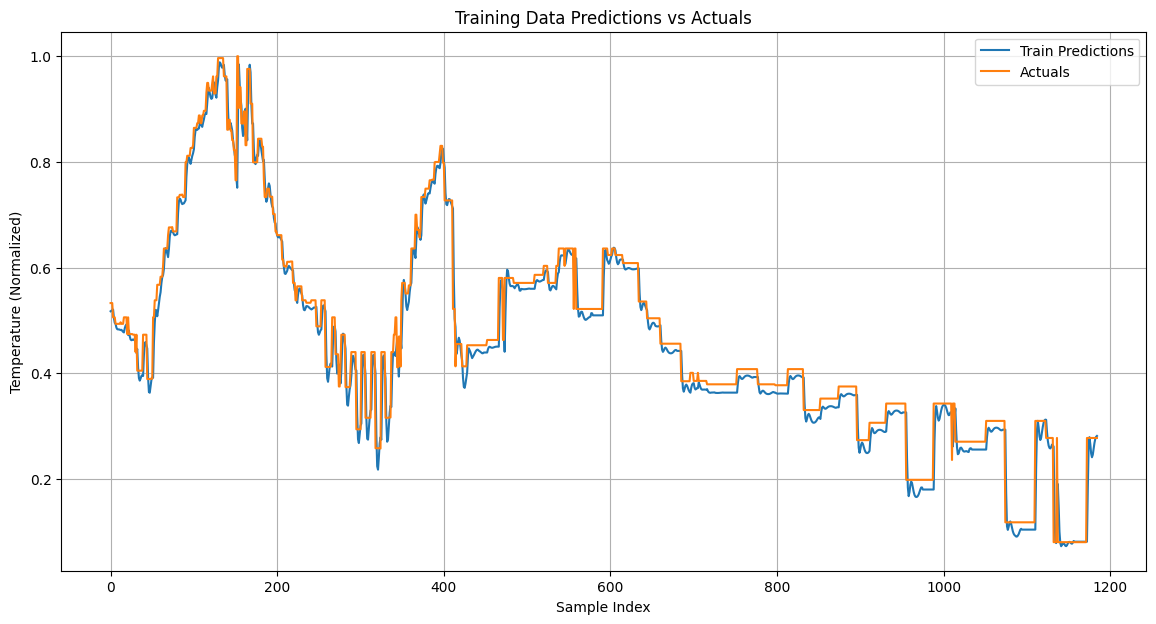

In [22]:
# Plot the training predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(train_results['Train Predictions'][:], label='Train Predictions')
plt.plot(train_results['Actuals'][:], label='Actuals')
plt.title('Training Data Predictions vs Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.grid(True)
plt.savefig('training_predictions_vs_actuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Tahminleri al ve düzleştir (1D yap)
val_predictions = model.predict(X_val).flatten()
y_val_flat = y_val.flatten() if y_val.ndim > 1 else y_val
val_results = pd.DataFrame(data={'Validation Predictions': val_predictions, 'Actuals': y_val_flat})


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


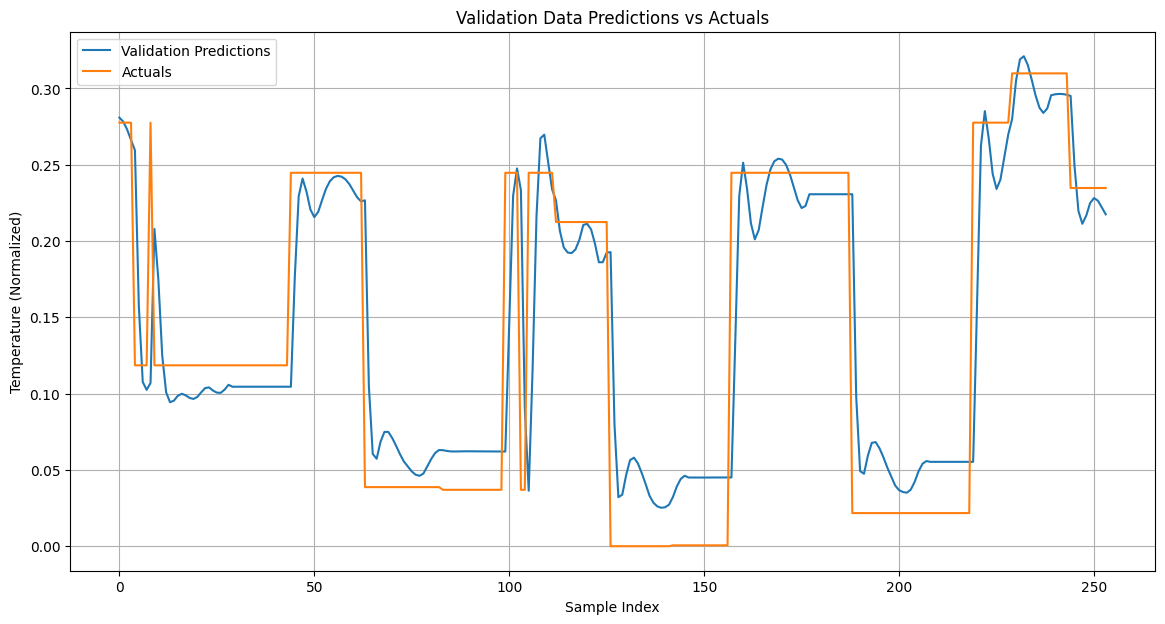

In [24]:
# Grafiği çiz ve kaydet
plt.figure(figsize=(14, 7))
plt.plot(val_results['Validation Predictions'][:], label='Validation Predictions')
plt.plot(val_results['Actuals'][:], label='Actuals')
plt.title('Validation Data Predictions vs Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.grid(True)
plt.savefig('val_predictions_vs_actuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# Make predictions on the test data
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': y_test.flatten()})

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


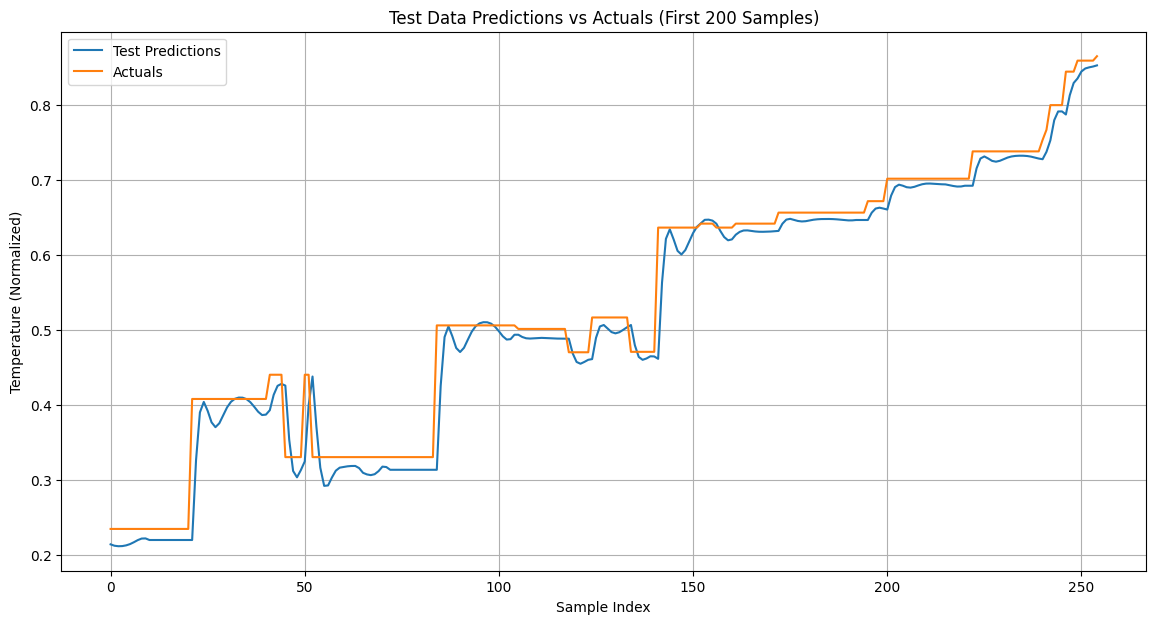

In [26]:
# Plot the test predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(test_results['Test Predictions'][:], label='Test Predictions')
plt.plot(test_results['Actuals'][:], label='Actuals')
plt.title('Test Data Predictions vs Actuals (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.grid(True)
plt.savefig('test_predictions_vs_actuals.png', dpi=300, bbox_inches='tight')
plt.show()


In [27]:
# Calculate and print R^2 Score and Mean Squared Error
r2 = r2_score(y_test, test_predictions)
print("R^2 Score:", r2)


R^2 Score: 0.968509949024337


In [28]:

mse = mean_squared_error(y_test, test_predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0009037406585391712


In [29]:
# Optionally: Reverse the normalization for easier interpretation of the results
test_predictions_original = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

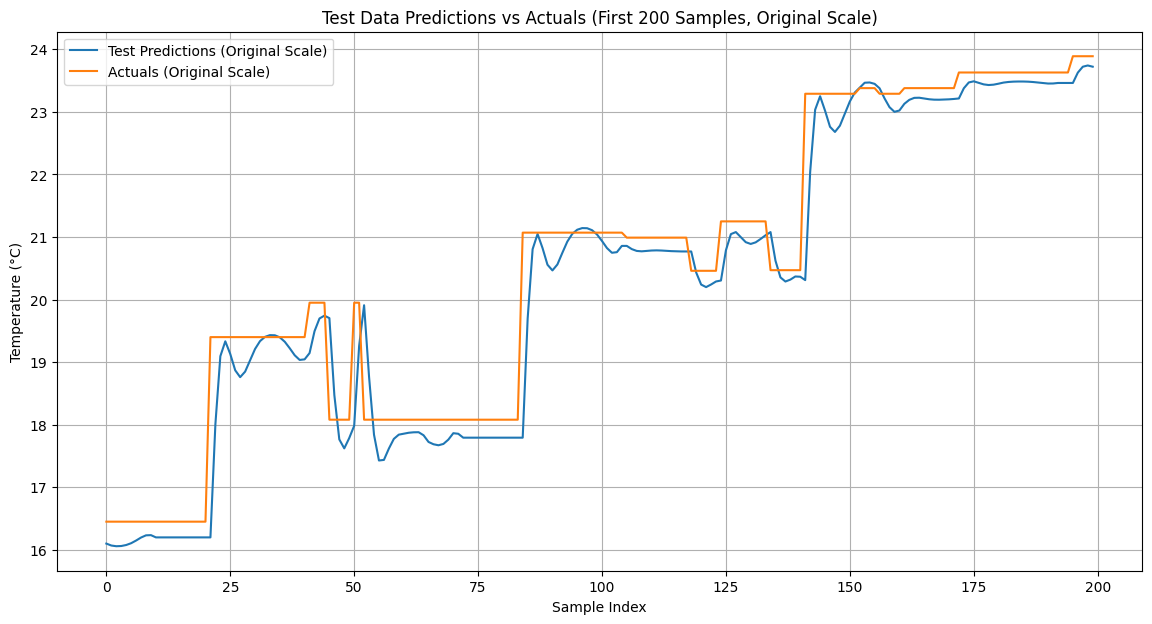

In [30]:
# Plot the original scale predictions vs actuals for better interpretation
plt.figure(figsize=(14, 7))
plt.plot(test_predictions_original[:200], label='Test Predictions (Original Scale)')
plt.plot(y_test_original[:200], label='Actuals (Original Scale)')
plt.title('Test Data Predictions vs Actuals (First 200 Samples, Original Scale)')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.savefig('test_predictions_vs_actuals_original_scale.png', dpi=300, bbox_inches='tight')

plt.show()

In [31]:
# Print the R^2 and MSE for the original scale predictions
r2_original = r2_score(y_test_original, test_predictions_original)
print("R^2 Score (Original Scale):", r2_original)

R^2 Score (Original Scale): 0.9685099571566717


In [32]:
mse_original = mean_squared_error(y_test_original, test_predictions_original)
print("Mean Squared Error (Original Scale):", mse_original)

Mean Squared Error (Original Scale): 0.2624115158304533


In [33]:
# Show predictions and actuals in a table (for test data)
test_results_table = pd.DataFrame({
    'Test Predictions (Normalized)': test_predictions,
    'Actuals (Normalized)': y_test.flatten(),
    'Test Predictions (Original Scale)': test_predictions_original,
    'Actuals (Original Scale)': y_test_original
})

# Optionally save the table to a CSV file
test_results_table.to_csv('test_results_comparison.csv', index=False)

# You can also display it directly in Jupyter Notebook using pandas
from IPython.display import display
display(test_results_table.head(20))  # Display the first 20 rows for a quick preview


,Test Predictions (Normalized),Actuals (Normalized),Test Predictions (Original Scale),Actuals (Original Scale)
0,0.214182,0.234742,16.099657,16.45
1,0.212363,0.234742,16.068670,16.45
2,0.211707,0.234742,16.057487,16.45
3,0.211892,0.234742,16.060642,16.45
4,0.212839,0.234742,16.076769,16.45
5,0.214528,0.234742,16.105564,16.45
6,0.217041,0.234742,16.148384,16.45
7,0.219860,0.234742,16.196421,16.45
8,0.221919,0.234742,16.231503,16.45
9,0.222101,0.234742,16.234596,16.45


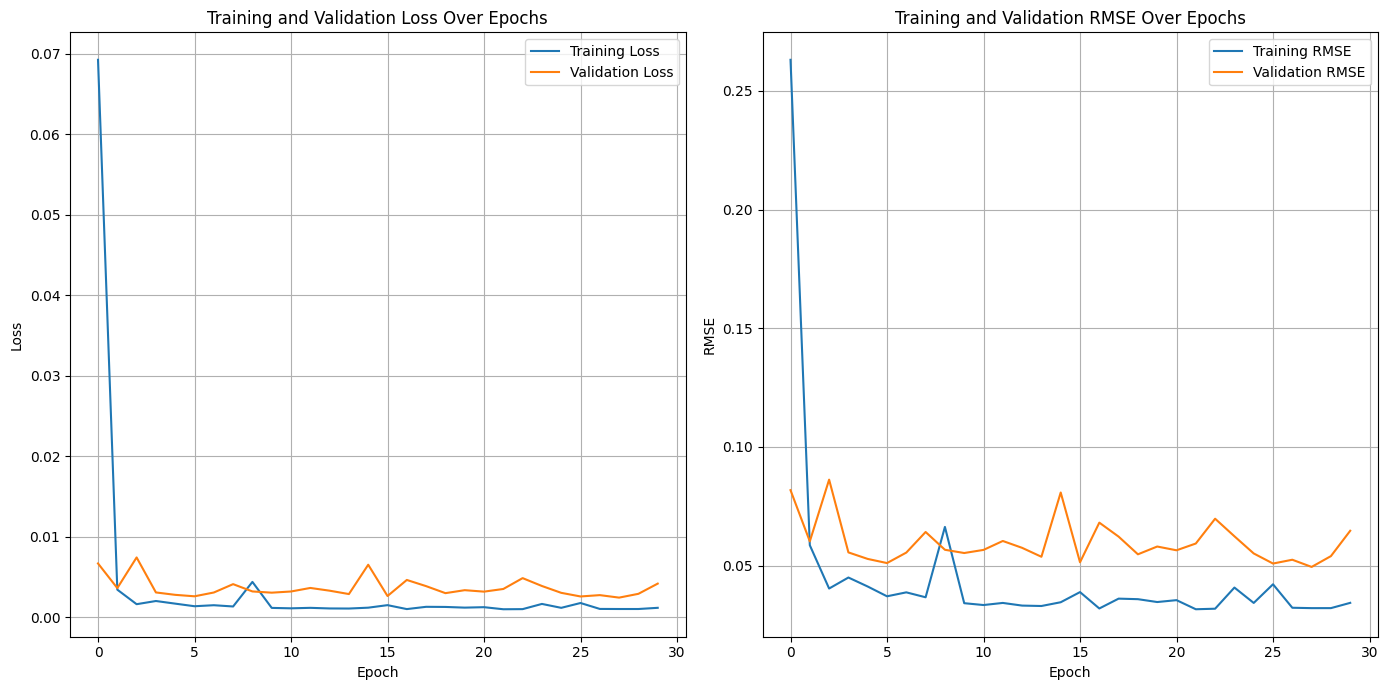

In [34]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()

# Plot training & validation loss values
plt.figure(figsize=(14, 7))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_and_validation_loss_over_epochs.png', dpi=300, bbox_inches='tight')


# RMSE grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.savefig('training_and_validation_rmse_over_epochs.png', dpi=300, bbox_inches='tight')

# Show both subplots
plt.tight_layout()
plt.show()
